In [27]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *

import json

from utils import *

In [2]:
# NUM_SAMPLES_PER_CLASS = 1_000
# NUM_VAL = 50 * 340

In [3]:
NUM_SAMPLES_PER_CLASS = 100
NUM_VAL = 20 * 340

In [4]:
PATH = Path('/home/nbuser/data/quickdraw/txt')

### Generate data from csvs

In [6]:
PATH.mkdir(exist_ok=True)
(PATH/'train').mkdir(exist_ok=True)
(PATH/'test').mkdir(exist_ok=True)

In [7]:
def create_train_txts_from_df(path):
    df = pd.read_csv(path)
    klass = '_'.join(path.stem.split())
    (PATH/'train'/klass).mkdir(exist_ok=True)
    for row in df.sample(NUM_SAMPLES_PER_CLASS).iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id,
            'recognized': row[1].recognized
        }
        with open(PATH/'train'/klass/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

def create_test_txts_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        example = {
            'countrycode': row[1].countrycode,
            'drawing': json.loads(row[1].drawing),
            'key_id': row[1].key_id
        }
        with open(PATH/'test'/f'{example["key_id"]}.txt', mode='w') as f: json.dump(example, f)

In [35]:
%time create_test_txts_from_df('/home/nbuser/data/quickdraw/test_simplified.csv')

CPU times: user 44 s, sys: 7.63 s, total: 51.6 s
Wall time: 51.8 s


In [36]:
%time for p in Path('/home/nbuser/data/quickdraw/train').iterdir(): create_train_txts_from_df(p)

CPU times: user 5min, sys: 22.5 s, total: 5min 22s
Wall time: 5min 39s


###  Create ImageDataBunch using the data block API

In [38]:
# sz = 128
# bs = 640

In [8]:
sz = 32
bs = 640

In [9]:
def create_func(path):
    with open(path) as f: j = json.load(f)
    drawing = list2drawing(j['drawing'], size=sz)
    tensor = drawing2tensor(drawing)
    return Image(tensor.div_(255))

In [10]:
item_list = ItemList.from_folder(PATH/'train', create_func=create_func)

In [11]:
idxs = np.arange(item_list.items.shape[0])
np.random.shuffle(idxs)
val_idxs = idxs[:NUM_VAL]

In [12]:
item_lists = item_list.split_by_idx(val_idxs)

In [13]:
label_lists = item_lists.label_from_folder()
pd.to_pickle(label_lists.train.y.classes, '/home/nbuser/data/quickdraw/classes.pkl')

In [14]:
classes = pd.read_pickle('/home/nbuser/data/quickdraw/classes.pkl')

label_lists = item_lists.label_from_folder(classes=classes)

test_items = ItemList.from_folder(PATH/'test', create_func=create_func)
label_lists.add_test(test_items);

In [15]:
train_dl = DataLoader(label_lists.train, bs, True, num_workers=12)
valid_dl = DataLoader(label_lists.valid, 2*bs, False, num_workers=12)
test_dl = DataLoader(label_lists.test, 2*bs, False, num_workers=12)

data_bunch = ImageDataBunch(train_dl, valid_dl, test_dl)

In [16]:
pd.to_pickle(data_bunch.batch_stats(), f'/home/nbuser/data/quickdraw/batch_stats_{sz}.pkl')

In [17]:
batch_stats = pd.read_pickle(f'/home/nbuser/data/quickdraw/batch_stats_{sz}.pkl')

In [18]:
data_bunch.normalize(batch_stats);

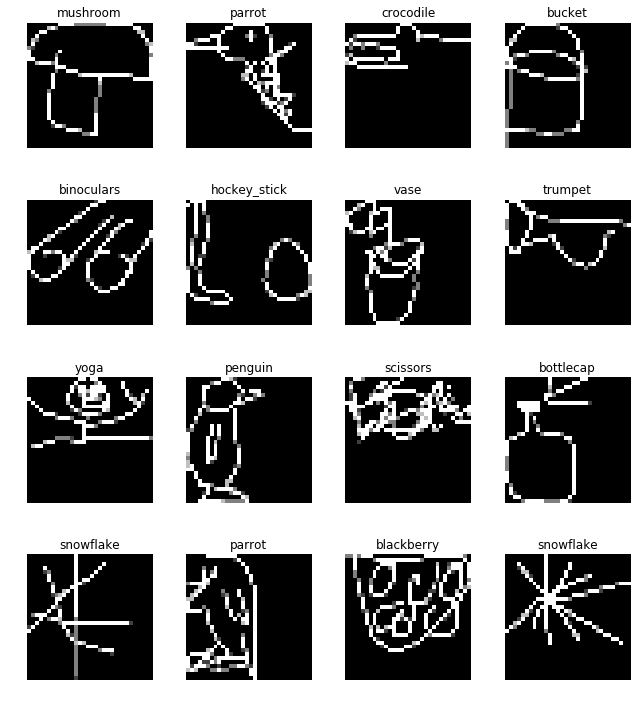

In [19]:
data_bunch.show_batch(rows=4)

### Train

In [20]:
name = f'res18-{sz}'

In [52]:
# learn = create_cnn(data_bunch, models.resnet34, metrics=[accuracy, map3])

In [21]:
learn = create_cnn(data_bunch, models.resnet18, metrics=[accuracy, map3])

In [54]:
learn.fit_one_cycle(2)

Total time: 00:34
epoch  train_loss  valid_loss  accuracy  map3    
1      5.126429    4.172521    0.156029  0.215343  (00:17)
2      4.184863    3.805861    0.211324  0.278652  (00:17)



In [55]:
learn.save(f'{name}-stage-1')

In [56]:
learn.unfreeze()

In [57]:
learn.fit_one_cycle(6, max_lr=6e-4)

Total time: 02:08
epoch  train_loss  valid_loss  accuracy  map3    
1      3.475762    3.092720    0.323971  0.408603  (00:23)
2      2.940909    2.667531    0.400735  0.490686  (00:20)
3      2.471266    2.385173    0.450147  0.542525  (00:20)
4      2.019845    2.204197    0.489853  0.579093  (00:20)
5      1.577934    2.114505    0.517647  0.602696  (00:20)
6      1.287102    2.104397    0.518529  0.604338  (00:20)



In [58]:
learn.save(f'{name}-stage-2')

### Predict

In [22]:
learn.load(f'{name}-stage-2');

In [23]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [35]:
create_submission(preds, data_bunch.test_dl, name, classes)

Saved to csv


In [36]:
pd.read_csv(f'/home/nbuser/data/quickdraw/{name}.csv.gz').head()

,key_id,word
0,9570467480642369,van bus school_bus
1,9612342540740332,calendar spreadsheet calculator
2,9981176623219988,clock compass baseball
3,9811147621565476,bathtub swan snorkel
4,9544081646255394,elbow foot leg


In [37]:
!kaggle competitions submit -c quickdraw-doodle-recognition -f /home/nbuser/data/quickdraw/{name}.csv.gz -m "{name}"

100%|██████████████████████████████████████| 1.55M/1.55M [00:01<00:00, 1.36MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge